In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sjoert.stellar import flux2mag
import pandas as pd
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from astropy.io import ascii
from scipy.constants import c,h,k
import os
from scipy.stats import kstest,ks_2samp

param_label_dict = {'sigma_rise':r'$\sigma_{\text{rise}}$','tau_dec':r'$\tau_{\text{dec}}$',
                    'log10_sigma_rise':r'$\sigma_{\text{rise}}$','log10_tau_dec':r'$\tau_{\text{dec}}$',
                    'F_p':r'F$_{\text{peak}}$','peak_g':r'F$_{\text{p,g}}$','peak_r':r'F$_{\text{p,r}}$','MBH':r'$\log_{10}($M$_{\text{BH}}/M_{\odot})$',
                    'dmg':r'$\Delta$m$_g$','dmr':r'$\Delta$m$_r$','opt_df_over_rms':r'$\Delta$F$_{\text{g}}$/F$_{\text{rms}}$',
                    'df_over_rms':r'Dust echo strength ($\\Delta$F$_{\\text{IR}}/\\text{F}_{\\text{rms}}$)'}

inv_param_label_dict = dict((v, k) for k, v in param_label_dict.items())

#==
#Load in the data
dpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data'
fullcatalogue = pd.read_csv(os.path.join(dpath,'transient_catalogue.txt'))
masked_catalogue = fullcatalogue[fullcatalogue['classified'].values]
# catalogue = fullcatalogue[fullcatalogue['in_selection']].iloc[:,:-2]

class_info = pd.read_csv(os.path.join(dpath,'transient_classinfo.txt'))
masked_class_info = class_info[class_info['fit_exists']]
#==
#get the df_over_rms data. These are yet another subset of the transients so we find them in the class_info frame
df_over_rms = ascii.read(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\ZTF_neoWISE_flares_parent.dat')[['name','df_over_rms']]
id_mask = np.isin(masked_class_info['ztf_id'].values,df_over_rms['name'])
class_info_for_rms = masked_class_info[id_mask]
#filter out zero MBHs
nonzero_mbh_for_rms = np.nonzero(class_info_for_rms['MBH'].values)
class_info_for_rms = class_info_for_rms.iloc[nonzero_mbh_for_rms]
df_over_rms_masked = df_over_rms[nonzero_mbh_for_rms]
#==
dpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data'

refmag_path = os.path.join(dpath,'refmags_good.txt')
refmag_df = pd.read_csv(refmag_path, sep=",")
refmag_df[refmag_df['ZTF_ID'] == 'ZTF19aaniqrr']

zeroref_g =  refmag_df['refmag_g'] == 0
zeroref_ztfs_g = refmag_df['ZTF_ID'][zeroref_g].values
bad_dmg = np.isin(fullcatalogue['ZTF_ID'].values,zeroref_ztfs_g)
fullcatalogue['bad_dmg'] = bad_dmg

zeroref_r = refmag_df['refmag_r'] == 0
zeroref_ztfs_r = refmag_df['ZTF_ID'][zeroref_r].values
bad_dmr = np.isin(fullcatalogue['ZTF_ID'].values,zeroref_ztfs_r)

fullcatalogue['bad_dmr'] = bad_dmr

### Trying some stuff with keras / ML
This is a MLP now, very simple with two layers. There's very little TDEs with well-known parameters (there's 55), so it's quite hard to train a model well.

In [116]:
tdemask = masked_class_info['classification'].values == 'TDE'
np.min(masked_catalogue['opt_df_over_rms'].values[tdemask])

375.7999616010938

In [154]:
y = masked_class_info['classification'].to_numpy()
unknownmask = (y != 'Unknown') * (masked_class_info['MBH'].values != 0) *(masked_class_info['MBH'].values <= 8) #* (masked_catalogue['opt_df_over_rms'].values >= 8)
fitqualitymask = masked_catalogue['fit_quality_good'].values
y = y[unknownmask * fitqualitymask]
Mbh = masked_class_info['MBH'].to_numpy()[unknownmask * fitqualitymask]

X = masked_catalogue[['ZTF_ID','dmg','dmr','log10_sigma_rise','log10_tau_dec','opt_df_over_rms']][unknownmask * fitqualitymask]
X['MBH'] = Mbh

X.drop('ZTF_ID',axis=1,inplace=True)
# X['df_over_rms'] = df_over_rms['df_over_rms'][df_over_rms_mask2]
X = X.to_numpy()
# X['class'] = y
np.unique(y,return_counts=True),y.shape

((array(['AGN', 'SN', 'TDE'], dtype=object),
  array([860,  30,  25], dtype=int64)),
 (915,))

In [155]:
# ##FOR ADDING DUST ECHO
# x_ztfs = X['ZTF_ID'].values
# df_over_rms_mask = np.isin(x_ztfs,np.array(df_over_rms['name']))
# df_over_rms_mask2 = np.isin(np.array(df_over_rms['name']),x_ztfs)
# X = X[df_over_rms_mask]
# X['df_over_rms'] = np.array(df_over_rms['df_over_rms'][df_over_rms_mask2])
# y = y[df_over_rms_mask]


In [156]:
np.random.seed(153286)
shuffle_array = np.random.rand(y.shape[0])
perm = np.argsort(shuffle_array)
X = X[perm]
y = y[perm]
np.unique(y)

array(['AGN', 'SN', 'TDE'], dtype=object)

In [157]:
# y[y != 'TDE'] = 0
y[y == 'TDE'] = 0
y[y == 'SN'] = 1
y[y == 'AGN'] = 2
print(np.unique(y))

[0 1 2]


In [158]:
import tensorflow as tf

size = int(0.8 * len(y))

Xtrain,ytrain = X[:size],y[:size]
Xtest,ytest = X[size:],y[size:]
ytrain_onehot = tf.keras.utils.to_categorical(ytrain)
ytest_onehot = tf.keras.utils.to_categorical(ytest)


In [159]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(Xtrain.shape[1],)))
model.add(tf.keras.layers.Dense(128))
# model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.Dense(len(np.unique(y)),activation='softmax'))
# model.summary()

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
# model.summary()
training_results = model.fit(Xtrain, 
                             ytrain_onehot, 
                             epochs=50, 
                             batch_size=128)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4919 - loss: 2.0991
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9469 - loss: 0.8758 
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9333 - loss: 0.7829 
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9112 - loss: 0.7081 
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9214 - loss: 0.6445 
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9389 - loss: 0.3320 
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9275 - loss: 0.4504 
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9476 - loss: 0.3293 
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9363 - loss: 0.3891 
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9354 - loss: 0.2726 
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9360 - loss: 0.2902 
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9484 - loss: 0.2430 
Ep

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


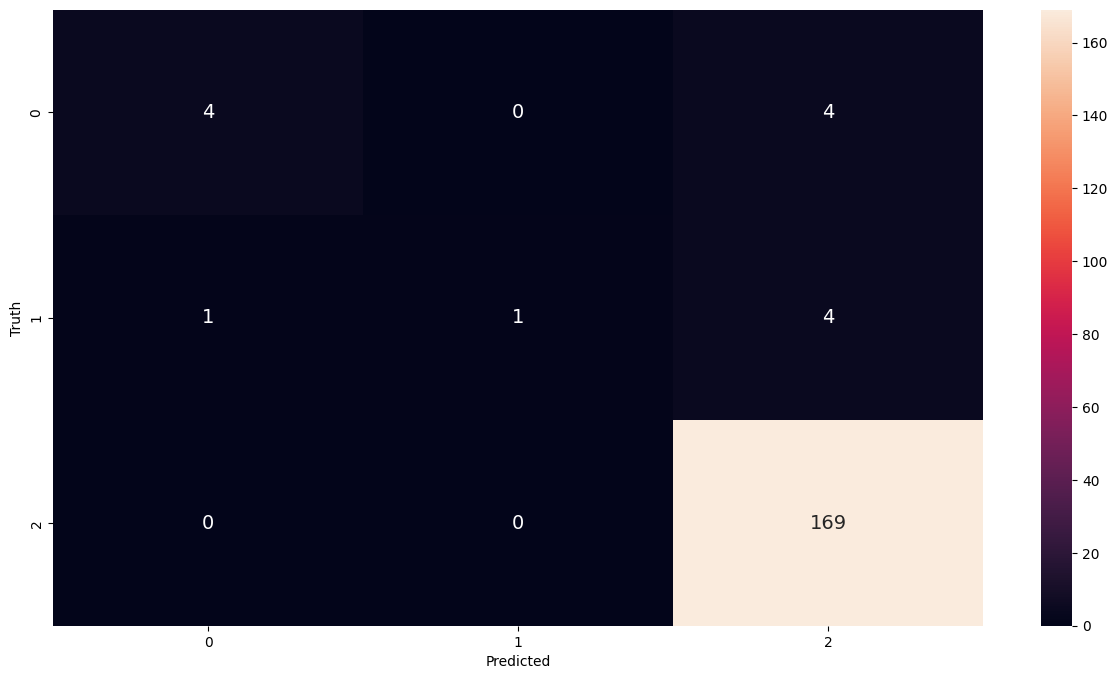

In [160]:
predictions = model.predict(Xtest)
labels = ['TDE','SN','AGN']
predicted_labels = [np.argmax(i) for i in predictions]
# Convert one-hot encoded labels to integers.
# y_test_integer_labels = tf.argmax(ytest_onehot, axis=1)
# print(ytest)
# # Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=ytest.astype(float), predictions=predicted_labels)
 
# # Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
# plt.imshow(cm)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


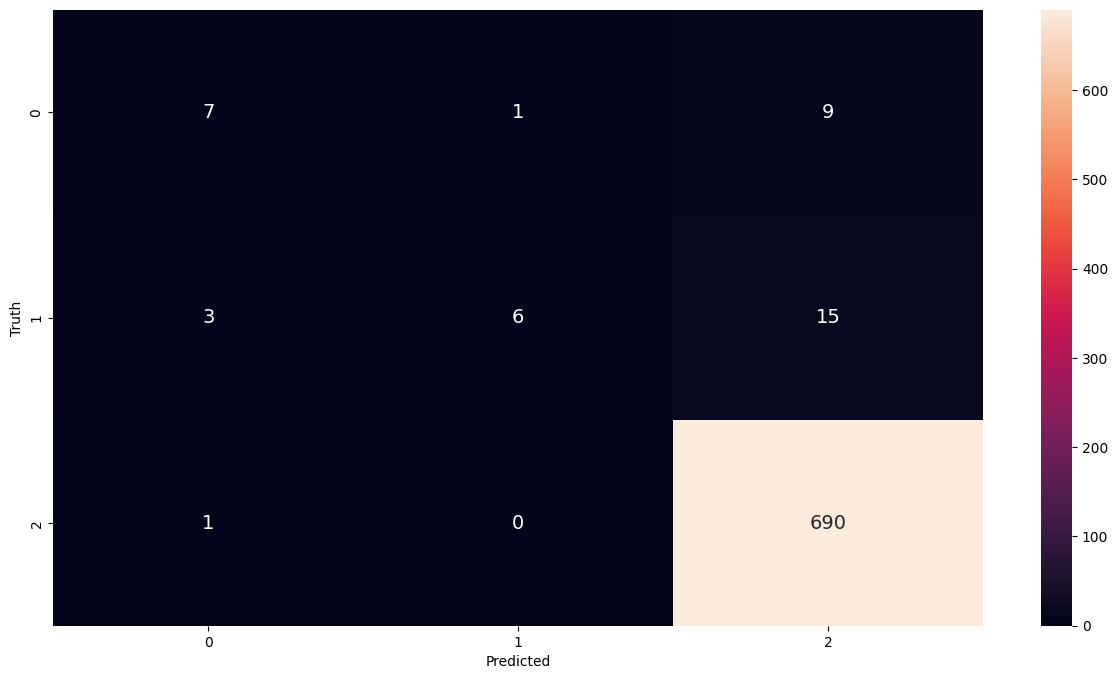

In [161]:
predictions = model.predict(Xtrain)
labels = {0:'Other',1:'TDE'}
predicted_labels = [np.argmax(i) for i in predictions]
# Convert one-hot encoded labels to integers.
# y_test_integer_labels = tf.argmax(ytest_onehot, axis=1)
# print(ytest)
# # Generate a confusion matrix for the test dataset.
cm = tf.math.confusion_matrix(labels=ytrain.astype(float), predictions=predicted_labels)
 
# # Plot the confusion matrix as a heatmap.
plt.figure(figsize=[15, 8])
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
# plt.imshow(cm)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()